In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import seaborn as sns
from datetime import date
import time
from math import ceil

In [2]:
#read the csv into a pandas dataframe
df = pd.read_csv('/Users/raffi/Desktop/galvanize/capstone_1/data/games.csv', delimiter = ',')

In [4]:
#dropping duplicated ids in dataframe
df.drop_duplicates(subset = ['id'], inplace = True)

In [5]:
#update moves column from string to list for future analysis
df.moves = df.moves.apply(lambda x: x.split(' '))

In [6]:
#categorize rating scale - 1517 below 1200, 12668 between 1400 - 2000, 1716 above 2000
#https://en.wikipedia.org/wiki/Chess_rating_system
#https://en.wikipedia.org/wiki/Elo_rating_system
#beginner < 1400 : 4729
#novice 1200 - 1999 : 12668
#expert 2000 - 2200 : 1169
#master > 2200 : 547

#df[(df['white_rating'] >= 2000) & (df['white_rating'] < 2200)].count()
#df[df['white_rating'] >= 2200].count()
#df[df['white_rating'] < 1400].count()

#categorize rating scales
def rating_cat_value(val):
    if val < 1400:
        return 'Beginner'
    elif val < 2000:
        return 'Novice'
    elif val < 2200:
        return 'Expert'
    elif val >= 2200:
        return 'Master'
    
def rating_cat_code(val):
    if val < 1400:
        return 1
    elif val < 2000:
        return 2
    elif val < 2200:
        return 3
    elif val >= 2200:
        return 4

df['white_rating_value'] = df['white_rating'].apply(rating_cat_value)
df['black_rating_value'] = df['black_rating'].apply(rating_cat_value)
df['white_rating_code'] = df['white_rating'].apply(rating_cat_code)
df['black_rating_code'] = df['black_rating'].apply(rating_cat_code)

In [7]:
#creating new column for main opening line - used to filter through variations
def opening_strip(opening):
    if ':' in opening:
        opening = opening.split(':')[0]
    while '|' in opening:
        opening = opening.split('|')[0]
    if '#' in opening:
        opening = opening.split('#')[0]
    if 'Accepted' in opening:
        opening = opening.replace('Accepted', '')
    if 'Declined' in opening:
        opening = opening.replace('Declined', '')
    if 'Refused' in opening:
        opening = opening.replace('Refused', '')
    return opening.strip()

df['main_opening'] = df['opening_name'].apply(opening_strip)

In [8]:
#creating two numerical columns for white win True / False and black win True / False
def white_winner(winner):
    if winner == 'white':
        return 1
    else:
        return 0

def black_winner(winner):
    if winner == 'black':
        return 1
    else:
        return 0 

def no_winner(winner):
    if winner == 'draw':
        return 1
    else:
        return 0 
    
df['white_winner'] = df['winner'].apply(white_winner)
df['black_winner'] = df['winner'].apply(black_winner)
df['no_winner'] = df['winner'].apply(no_winner)

In [9]:
#adding new column of data - date
date = pd.to_datetime(df['created_at'], errors = 'ignore', unit = 'ms')
df['date'] = pd.DatetimeIndex(date).date

In [20]:
datedf = df.copy()
datedf.index = pd.to_datetime(datedf['date'])
op = datedf.groupby(by = datedf.index.year).agg({'opening_ply': 'mean'})
turns = datedf.groupby(by = datedf.index.year).agg({'turns': 'mean'})
rating = datedf.groupby(by = datedf.index.year).agg({'white_rating': 'mean'})
v_status = datedf.groupby(by = datedf.index.year).agg({'victory_status' : 'count'})

In [153]:
!pwd

/Users/raffi/Desktop/galvanize/capstone_1


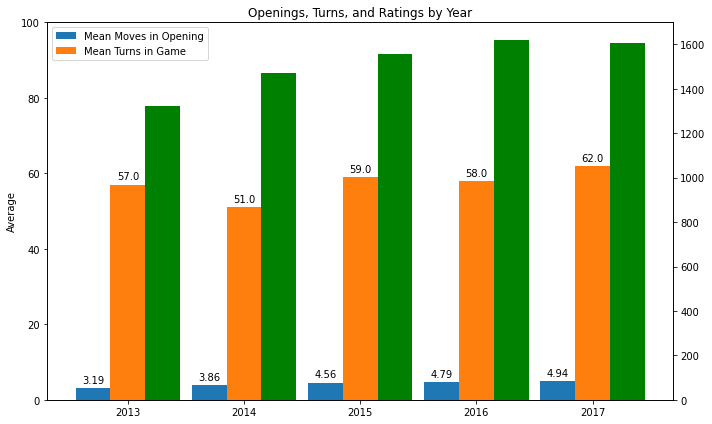

In [154]:
labels = ['2013', '2014', '2015', '2016', '2017']
x = np.arange(len(labels))
width = 0.30
fig, ax = plt.subplots(figsize = (10,6))
ax2 = ax.twinx()
rects1 = ax.bar(x - width, op.opening_ply.round(2), width, label = 'Mean Moves in Opening')
rects2 = ax.bar(x, turns.turns.round(0), width, label = 'Mean Turns in Game')
rects3 = ax2.bar(x + width, rating.white_rating.round(0), width, label = 'Mean Turns in Game', color = 'g')

ax.set_ylabel('Average')
ax.set_title('Openings, Turns, and Ratings by Year')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(top = 100)

ax.legend(loc = 'upper left')

def autolabel(rects):
    '''Attach a text label above each bar'''
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                   xy = (rect.get_x() + rect.get_width() / 2, height),
                   xytext = (0, 3), 
                   textcoords = 'offset points',
                   ha = 'center', va = 'bottom')


#height3 = rects3.get_height()        
#ax3.annotate('{}'.format(height3), xy = (rects3.get_x() + rects3.get_width() / 2, height3),
#             xytext = (0,3), textcoords = 'offset points', ha = 'center', va = 'bottom')

autolabel(rects1)
autolabel(rects2)
# autolabel(rects3)

fig.tight_layout()
plt.savefig('images/Openings, Turns, and Ratings by Year.png')

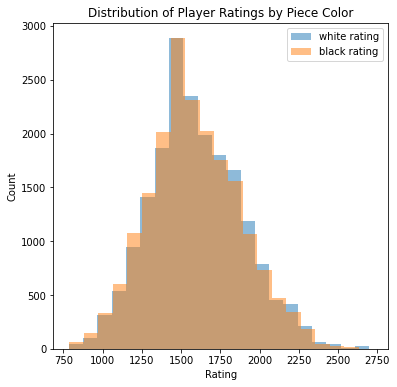

In [91]:
#distribution of ratings by group
fig,ax = plt.subplots(1,1, figsize = (6,6))
bins = 21
ax.set_title('Distribution of Player Ratings by Piece Color')
ax.set_ylabel('Count')
ax.set_xlabel('Rating')
ax.hist(df['white_rating'], bins, alpha = 0.5, align = 'mid', label = 'white rating')
ax.hist(df['black_rating'], bins, alpha = 0.5, align = 'mid', label = 'black rating')
ax.legend();



In [95]:
df['white_rating'].mean(), df['black_rating'].mean()

(1597.300005232041, 1590.045518756867)

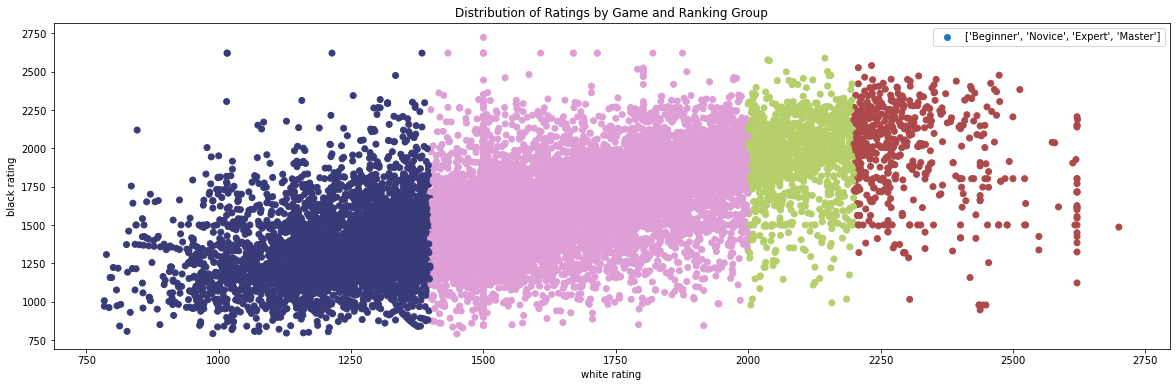

In [102]:
#distribution of games by rating and rating group
fig, ax = plt.subplots(1,1, figsize = (20,6))
labels = ['Beginner', 'Novice', 'Expert', 'Master']
ax.scatter(df.white_rating, df.black_rating, c = pd.Categorical(df.white_rating_value).codes, cmap = 'tab20b', label = labels)
ax.set_ylabel('black rating')
ax.set_xlabel('white rating')
ax.set_title('Distribution of Ratings by Game and Ranking Group')
ax.legend();

In [108]:
df['white_rating'].mean(), df['black_rating'].mean()

(1597.300005232041, 1590.045518756867)

In [106]:
openings_grouped = df.groupby(['main_opening', 'white_rating_value'])['id'].count()
openings_grouped = pd.DataFrame(openings_grouped).reset_index()
openings_grouped = openings_grouped.pivot(index = 'main_opening', columns = 'white_rating_value', values = 'id')
openings_grouped.fillna(0, inplace = True)
openings_grouped['total'] = openings_grouped['Beginner'] + openings_grouped['Expert'] + openings_grouped['Novice'] + openings_grouped['Master']
openings_grouped.sort_values(by = 'total', ascending = False, inplace = True)

No handles with labels found to put in legend.


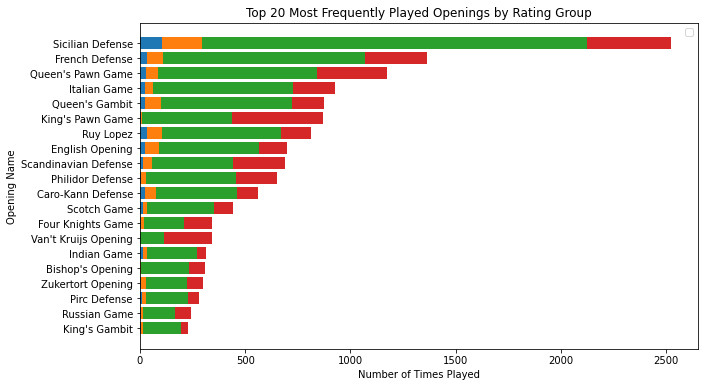

In [112]:
#top 20 most frequent openings played by ranking group
fig, ax = plt.subplots(1,1, figsize = (10,6))
labels = ['Beginner', 'Novice', 'Expert', 'Master']
x_pos = [i for i in openings_grouped.index[0:20]]
b = np.array(openings_grouped['Beginner'][0:20])
n = np.array(openings_grouped['Novice'][0:20])
e = np.array(openings_grouped['Expert'][0:20])
m = np.array(openings_grouped['Master'][0:20])
ax.set_title('Top 20 Most Frequently Played Openings by Rating Group')
ax.set_ylabel('Opening Name')
ax.set_xlabel('Number of Times Played')
ax.barh(x_pos, m)
ax.barh(x_pos, e, left = m)
ax.barh(x_pos, n, left = m + e)
ax.barh(x_pos, b, left = m + e + n)
ax.set_ylim(ax.get_ylim()[::-1])
ax.legend();

In [117]:
openings_grouped.sort_values(by = 'Master', ascending = False, inplace = True)

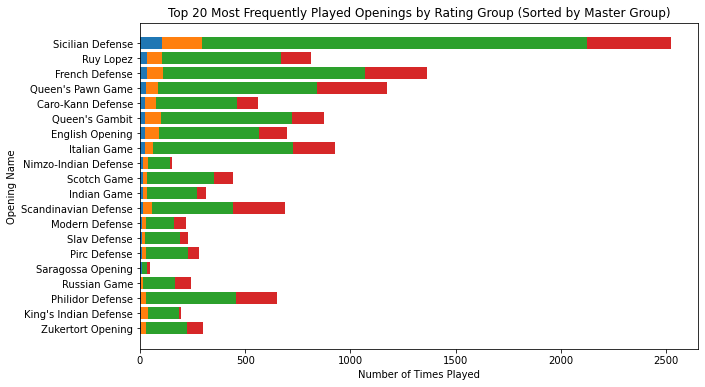

In [118]:
#top 20 most frequent master openings played by ranking group
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in openings_grouped.index[0:20]]
b = np.array(openings_grouped['Beginner'][0:20])
n = np.array(openings_grouped['Novice'][0:20])
e = np.array(openings_grouped['Expert'][0:20])
m = np.array(openings_grouped['Master'][0:20])
ax.set_title('Top 20 Most Frequently Played Openings by Rating Group (Sorted by Master Group)')
ax.set_ylabel('Opening Name')
ax.set_xlabel('Number of Times Played')
ax.barh(x_pos, m)
ax.barh(x_pos, e, left = m)
ax.barh(x_pos, n, left = m + e)
ax.barh(x_pos, b, left = m + e + n)
ax.set_ylim(ax.get_ylim()[::-1]);

In [119]:
openings_grouped['Beginner_%'] = openings_grouped['Beginner'] / openings_grouped['Beginner'].sum()
openings_grouped['Expert_%'] = openings_grouped['Expert'] / openings_grouped['Expert'].sum()
openings_grouped['Master_%'] = openings_grouped['Master'] / openings_grouped['Master'].sum()
openings_grouped['Novice_%'] = openings_grouped['Novice'] / openings_grouped['Novice'].sum()

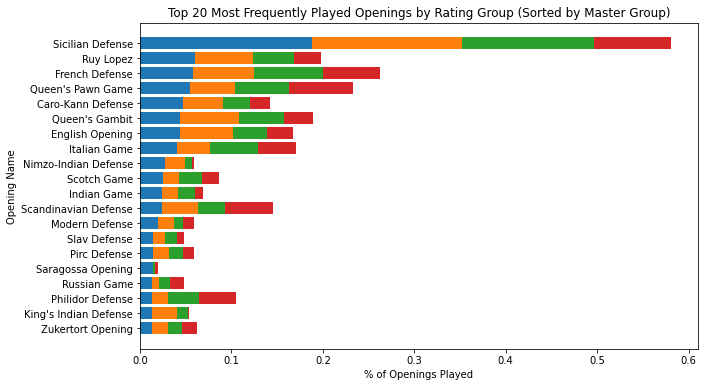

In [122]:
#top 20 master openings % played by group
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in openings_grouped.index[0:20]]
b = np.array(openings_grouped['Beginner_%'][0:20])
n = np.array(openings_grouped['Novice_%'][0:20])
e = np.array(openings_grouped['Expert_%'][0:20])
m = np.array(openings_grouped['Master_%'][0:20])
ax.set_title('Top 20 Most Frequently Played Openings by Rating Group (Sorted by Master Group)')
ax.set_ylabel('Opening Name')
ax.set_xlabel('% of Openings Played')
ax.barh(x_pos, m)
ax.barh(x_pos, e, left = m)
ax.barh(x_pos, n, left = m + e)
ax.barh(x_pos, b, left = m + e + n)
ax.set_ylim(ax.get_ylim()[::-1]);

In [123]:
sicilian = df[df['main_opening'] == 'Sicilian Defense']
s = sicilian.groupby(['winner', 'black_rating_value'])['id'].count()
s = pd.DataFrame(s).reset_index()
s = s.pivot(index = 'black_rating_value', columns = 'winner', values = 'id')
s['total'] = s['black'] + s['draw'] + s['white']
s['win_%'] = s['black'] / s['total']
s['lose_%'] = s['white'] / s['total']
s['draw_%'] = s['draw'] / s['total']
s

winner,black,draw,white,total,win_%,lose_%,draw_%
black_rating_value,,,,,,,
Beginner,125,13,205,343,0.364431,0.597668,0.037901
Expert,134,16,81,231,0.580087,0.350649,0.069264
Master,65,7,26,98,0.663265,0.265306,0.071429
Novice,923,88,843,1854,0.497843,0.454693,0.047465


In [124]:
def sicilian(main_opening):
    if main_opening == 'Sicilian Defense':
        return 1
    else:
        return 0

In [125]:
#master sicilian vs novice sicilian mean - t-test equal variance = false
black_masters = df[df['black_rating_value'] == 'Master'].copy()
black_novices = df[df['black_rating_value'] == 'Novice'].copy()
black_masters['sicilian'] = black_masters['main_opening'].apply(sicilian)
black_novices['sicilian'] = black_novices['main_opening'].apply(sicilian)

In [126]:
black_masters_mean = black_masters['sicilian'].sum() / black_masters['sicilian'].count()
black_novices_mean = black_novices['sicilian'].sum() / black_novices['sicilian'].count()
black_masters_mean, black_novices_mean

(0.19678714859437751, 0.14807124031626867)

In [127]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
ttest = stats.ttest_ind(black_masters['sicilian'], black_novices['sicilian'], equal_var = False)
ttest
#reject the null hypothesis of equal averages

Ttest_indResult(statistic=2.689444550967454, pvalue=0.00738306766431855)

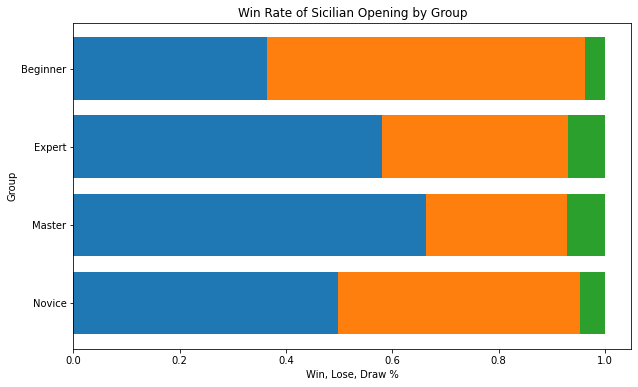

In [129]:
#percent sicilian win by ranking
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in s.index]
w = np.array(s['win_%'])
l = np.array(s['lose_%'])
d = np.array(s['draw_%'])
ax.set_title('Win Rate of Sicilian Opening by Group')
ax.set_ylabel('Group')
ax.set_xlabel('Win, Lose, Draw %')

ax.barh(x_pos, w)
ax.barh(x_pos, l, left = w)
ax.barh(x_pos, d, left = w + l)

ax.set_ylim(ax.get_ylim()[::-1]);

In [130]:
white_wins_grouped = df.groupby(['white_rating_value', 'winner'])['id'].count()
white_wins_grouped = pd.DataFrame(white_wins_grouped).reset_index()
white_wins_grouped = white_wins_grouped.pivot(index = 'white_rating_value', columns = 'winner', values = 'id')
white_wins_grouped['total'] = white_wins_grouped['black'] + white_wins_grouped['white'] + white_wins_grouped['draw']
white_wins_grouped['white_%'] = white_wins_grouped['white'] / white_wins_grouped['total']
white_wins_grouped['black_%'] = white_wins_grouped['black'] / white_wins_grouped['total']
white_wins_grouped['draw_%'] = white_wins_grouped['draw'] / white_wins_grouped['total']
black_wins_grouped = df.groupby(['black_rating_value', 'winner'])['id'].count()
black_wins_grouped = pd.DataFrame(black_wins_grouped).reset_index()
black_wins_grouped = black_wins_grouped.pivot(index = 'black_rating_value', columns = 'winner', values = 'id')
black_wins_grouped['total'] = black_wins_grouped['black'] + black_wins_grouped['white'] + black_wins_grouped['draw']
black_wins_grouped['white_%'] = black_wins_grouped['white'] / black_wins_grouped['total']
black_wins_grouped['black_%'] = black_wins_grouped['black'] / black_wins_grouped['total']
black_wins_grouped['draw_%'] = black_wins_grouped['draw'] / black_wins_grouped['total']

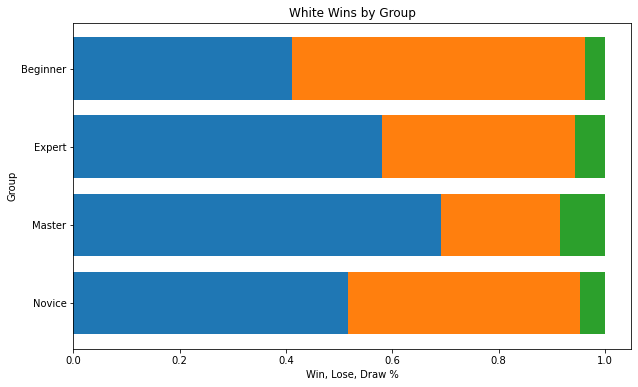

In [132]:
#percent win by ranking category
#need to shift
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in white_wins_grouped.index]
ww = np.array(white_wins_grouped['white_%'])
wb = np.array(white_wins_grouped['black_%'])
wd = np.array(white_wins_grouped['draw_%'])
ax.set_title('White Wins by Group')
ax.set_ylabel('Group')
ax.set_xlabel('Win, Lose, Draw %')
ax.barh(x_pos, ww)
ax.barh(x_pos, wb, left = ww)
ax.barh(x_pos, wd, left = ww + wb)
ax.set_ylim(ax.get_ylim()[::-1]);

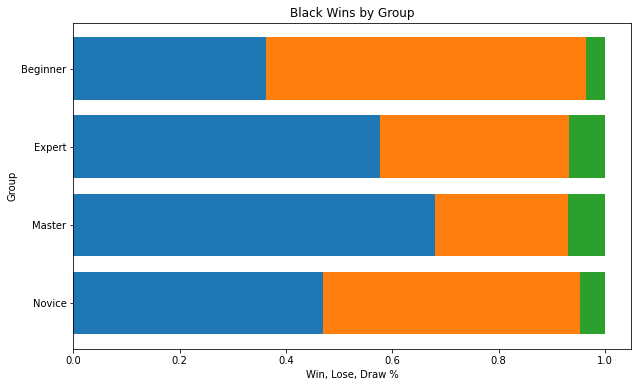

In [133]:
#percent win by ranking category
#need to shift
fig, ax = plt.subplots(1,1, figsize = (10,6))
x_pos = [i for i in black_wins_grouped.index]
ww = np.array(black_wins_grouped['white_%'])
bw = np.array(black_wins_grouped['black_%'])
bd = np.array(black_wins_grouped['draw_%'])
ax.set_title('Black Wins by Group')
ax.set_ylabel('Group')
ax.set_xlabel('Win, Lose, Draw %')
ax.barh(x_pos, bw)
ax.barh(x_pos, ww, left = bw)
ax.barh(x_pos, bd, left = bw + ww)
ax.set_ylim(ax.get_ylim()[::-1]);

In [134]:
white_wins_grouped

winner,black,draw,white,total,white_%,black_%,draw_%
white_rating_value,,,,,,,
Beginner,2606,180,1943,4729,0.410869,0.551068,0.038063
Expert,426,65,678,1169,0.579983,0.364414,0.055603
Master,123,46,378,547,0.691042,0.224863,0.084095
Novice,5525,597,6546,12668,0.516735,0.436138,0.047127


In [135]:
black_wins_grouped

winner,black,draw,white,total,white_%,black_%,draw_%
black_rating_value,,,,,,,
Beginner,1768,175,2942,4885,0.602252,0.361924,0.035824
Expert,698,81,430,1209,0.355666,0.577337,0.066998
Master,339,35,124,498,0.248996,0.680723,0.070281
Novice,5875,597,6049,12521,0.483108,0.469212,0.047680


In [141]:
beginner = white_wins_grouped['white_%']['Beginner'] - black_wins_grouped['black_%']['Beginner']
novice = white_wins_grouped['white_%']['Novice'] - black_wins_grouped['black_%']['Novice']
expert = white_wins_grouped['white_%']['Expert'] - black_wins_grouped['black_%']['Expert']
master = white_wins_grouped['white_%']['Master'] - black_wins_grouped['black_%']['Master']

In [143]:
beginner.round(3), novice.round(3), expert.round(3), master.round(3)

(0.049, 0.048, 0.003, 0.01)

In [145]:
wb_total = white_wins_grouped.loc['Beginner']['total']
wb_mean = white_wins_grouped.loc['Beginner']['white_%']
bb_total = black_wins_grouped.loc['Beginner']['total']
bb_mean = black_wins_grouped.loc['Beginner']['black_%']
(wb_total, wb_mean), (bb_total, bb_mean)

((4729.0, 0.41086910551913725), (4885.0, 0.36192425793244626))

In [146]:
shared_sample_freq = ((wb_total * wb_mean) + (bb_total * bb_mean)) / (wb_total + bb_total)
shared_sample_variance = (wb_total + bb_total) * (shared_sample_freq * (1 - shared_sample_freq)) / (wb_total * bb_total)

difference_in_proportions = stats.norm(0, np.sqrt(shared_sample_variance))

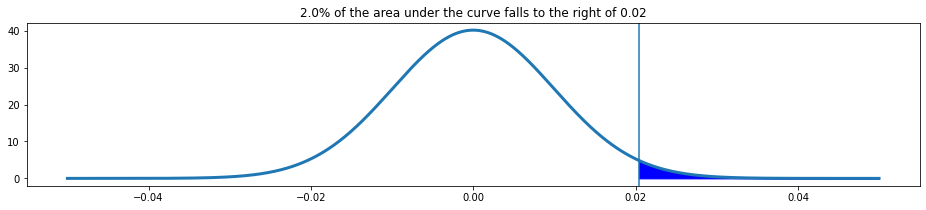

In [147]:
a = 0.02
x = np.linspace(-0.05, .05, num=5000)
threshold = difference_in_proportions.ppf(1-a)

fig, ax = plt.subplots(1, figsize=(16, 3))
ax.plot(x, difference_in_proportions.pdf(x), linewidth=3)
ax.axvline(threshold)
ax.fill_between(x, 0, difference_in_proportions.pdf(x), x>threshold, color = 'blue')
ax.set_title(f'{100*a}% of the area under the curve falls to the right of {round(threshold,3)}');



In [148]:
wb_sample_freq = (wb_total * wb_mean) / wb_total
bb_sample_freq = (bb_total * bb_mean) / bb_total

print(f"White Beginner Frequency: {wb_sample_freq}, Black Beginner Frequency: {bb_sample_freq}")
difference_in_sample_proportions = wb_sample_freq - bb_sample_freq
print("Difference in sample proportions: {:2.2f}".format(difference_in_sample_proportions))

White Beginner Frequency: 0.41086910551913725, Black Beginner Frequency: 0.36192425793244626
Difference in sample proportions: 0.05


In [149]:
p_value = 1 - difference_in_proportions.cdf(difference_in_sample_proportions)
print("p-value for kickfip frequency comparison: {:2.8f}".format(p_value))


p-value for kickfip frequency comparison: 0.00000041
